In [1]:
import csv
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_trials = 10


In [2]:
import tqdm

model_names = [
    "icassp-convnet", "icassp-convnet_aug-all-but-noise", "icassp-convnet_aug-all", 
    "pcen-convnet", "pcen-convnet_aug-all-but-noise", "pcen-convnet_aug-all",
    "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all",
    "pcen-ntt-convnet", "pcen-ntt-convnet_aug-all-but-noise", "pcen-ntt-convnet_aug-all",
    "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all",
    "pcen-add-convnet", "pcen-add-convnet_aug-all-but-noise", "pcen-add-convnet_aug-all",
]

n_models = len(model_names)


fold_accs = []
for fold_id in range(6):

    model_accs = {}

    for model_name in tqdm.tqdm(model_names):
        
        val_accs = []
        
        for trial_id in range(10):

            model_dir = os.path.join(models_dir, model_name)
            test_unit_str = units[fold_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            
            val_unit_strs = localmodule.fold_units()[fold_id][2]
            
            val_tn = 0
            val_tp = 0
            val_fn = 0
            val_fp = 0
            
            for val_unit_str in val_unit_strs:

                predictions_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + val_unit_str,
                    "clip-predictions.csv"
                ])

                prediction_path = os.path.join(
                    trial_dir, predictions_name)

                # Load prediction.
                try:
                    with open(prediction_path, 'r') as f:
                        reader = csv.reader(f)
                        rows = list(reader)
                    rows = [",".join(row) for row in rows]
                    rows = rows[1:]
                    rows = "\n".join(rows)

                    # Parse rows with correct header.
                    df = pd.read_csv(StringIO(rows),
                        names=[
                            "Dataset",
                            "Test unit",
                            "Prediction unit",
                            "Timestamp",
                            "Center Freq (Hz)",
                            "Augmentation",
                            "Key",
                            "Ground truth",
                            "Predicted probability"])
                    y_pred = np.array(df["Predicted probability"])

                    y_pred = (y_pred > 0.5).astype('int')

                    # Load ground truth.
                    y_true = np.array(df["Ground truth"])

                    # Compute confusion matrix.
                    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                        y_true, y_pred).ravel()

                    val_tn = val_tn + tn
                    val_fp = val_fp + fp
                    val_fn = val_fn + fn
                    val_tp = val_tp + tp

                except:
                    val_tn = -np.inf
                    val_tp = -np.inf
                    val_fn = -np.inf
                    val_tp = -np.inf
                    
            if val_tn < 0:
                val_acc = 0.0
            else:
                val_acc =\
                    100 * (val_tn+val_tp) /\
                    (val_tn+val_tp+val_fn+val_fp)
            
            val_accs.append(val_acc)
        
        # Remove the models that did not train (accuracy close to 50%, i.e. chance)
        val_accs = [v for v in val_accs if v > 65.0]
        model_accs[model_name] = val_accs
        
    fold_accs.append(model_accs)

100%|██████████| 18/18 [00:39<00:00,  2.19s/it]


In [4]:
fold_accs

[{'icassp-add-convnet': [95.904704914354099],
  'icassp-add-convnet_aug-all': [96.607824070611116,
   97.696162764604679,
   95.758845089385886,
   96.510584187298974,
   98.077642306829233,
   97.307203231356127],
  'icassp-add-convnet_aug-all-but-noise': [97.823322612012859,
   97.838282594060885,
   96.106664672002395,
   97.236143316628016],
  'icassp-convnet': [96.312364425162684,
   97.348343181988184,
   93.215648141222232,
   96.619044057147136,
   97.213703343555991,
   96.260004487994621,
   87.830054603934471],
  'icassp-convnet_aug-all': [91.64111003066796,
   94.464806642232034,
   95.212805744633101,
   92.901488518213782,
   87.878674545590542,
   97.68494277806866,
   96.794823846211386,
   97.262323285212062,
   76.022888772533477],
  'icassp-convnet_aug-all-but-noise': [96.398384321938821,
   95.283865659361211,
   97.127683446779869,
   95.549405340713591,
   97.000523599371675,
   97.030443563467728,
   94.558306530032169,
   94.936046076744702,
   96.64522402573116

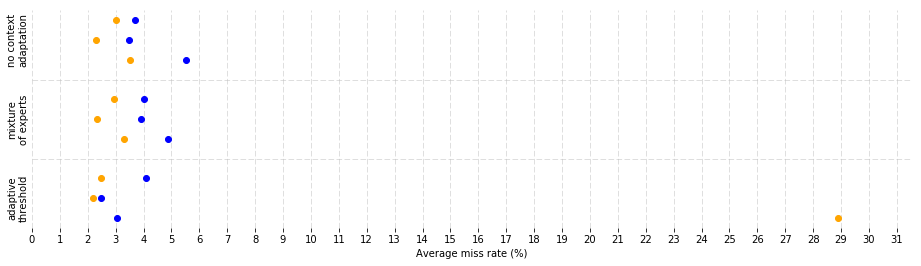

In [5]:
fold_id = 0

#model_accs = np.stack(list(fold_accs[fold_id].values()))[:,:]
#plt.boxplot(model_accs.T);

model_names = [
    "icassp-convnet", "icassp-convnet_aug-all-but-noise", "icassp-convnet_aug-all", 
    "pcen-convnet", "pcen-convnet_aug-all-but-noise", "pcen-convnet_aug-all",
    "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all",
    "pcen-ntt-convnet", "pcen-ntt-convnet_aug-all-but-noise", "pcen-ntt-convnet_aug-all",
    "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all",
    "pcen-add-convnet", "pcen-add-convnet_aug-all-but-noise", "pcen-add-convnet_aug-all",
]




errs = 100 - np.stack([np.median(x) for x in list(fold_accs[fold_id].values())])
xmax = np.ceil(np.max(errs)) + 2.5

fig = plt.figure(figsize=(xmax/2, 4), frameon=False)

plt.plot(errs[0], [0], 'o', color='blue');
plt.plot(errs[1], [1], 'o', color='blue');
plt.plot(errs[2], [2], 'o', color='blue');

plt.plot(errs[3], [0], 'o', color='orange');
plt.plot(errs[4], [1], 'o', color='orange');
plt.plot(errs[5], [2], 'o', color='orange');

plt.text(-0.5, 1, 'no context\nadaptation',
    horizontalalignment='center',
    verticalalignment='center',
    rotation=90, wrap=True)

#plt.text(max(errs[0], errs[3]) + 1, 0, 'none');
#plt.text(max(errs[1], errs[4]) + 1, 1, 'geometrical');
#plt.text(max(errs[2], errs[5]) + 1, 2, 'adaptive');


plt.plot(errs[6], [4], 'o', color='blue');
plt.plot(errs[7], [5], 'o', color='blue');
plt.plot(errs[8], [6], 'o', color='blue');

plt.plot(errs[9], [4], 'o', color='orange');
plt.plot(errs[10], [5], 'o', color='orange');
plt.plot(errs[11], [6], 'o', color='orange');

plt.text(-0.5, 5, 'mixture\nof experts',
    horizontalalignment='center',
    verticalalignment='center',
    rotation=90, wrap=True)

#plt.text(max(errs[6], errs[9]) + 1, 4, 'none');
#plt.text(max(errs[7], errs[10]) + 1, 5, 'geometrical');
#plt.text(max(errs[8], errs[11]) + 1, 6, 'adaptive');


plt.plot(errs[12], [8], 'o', color='blue');
plt.plot(errs[13], [9], 'o', color='blue');
plt.plot(errs[14], [10], 'o', color='blue');

plt.plot(errs[15], [8], 'o', color='orange');
plt.plot(errs[16], [9], 'o', color='orange');
plt.plot(errs[17], [10], 'o', color='orange');

plt.text(-0.5, 9, 'adaptive\nthreshold',
    horizontalalignment='center',
    verticalalignment='center',
    rotation=90, wrap=True)

#plt.text(max(errs[12], errs[15]) + 1, 8, 'none');
#plt.text(max(errs[13], errs[16]) + 1, 9, 'geometrical');
#plt.text(max(errs[14], errs[17]) + 1, 10, 'adaptive');


plt.plot([0, xmax], [3, 3], '--', color=[0.75, 0.75, 0.75], linewidth=1.0, alpha=0.5)
plt.plot([0, xmax], [7, 7], '--', color=[0.75, 0.75, 0.75], linewidth=1.0, alpha=0.5)

plt.xlim([0.0, xmax])
plt.ylim([10.5, -0.5])

ax = fig.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_yaxis().set_ticks([])

fig.gca().set_xticks(range(0, int(xmax)+1, 1));
fig.gca().xaxis.grid(linestyle='--', alpha=0.5)

plt.xlabel("Average miss rate (%)")

#plt.savefig("spl_bv-70k-benchmark_fold-" + units[fold_id] + ".eps")

[' 1', '1.5', ' 2', '2.5', ' 3', ' 4', ' 5', ' 6', ' 8', '10', '12', '16', '20']


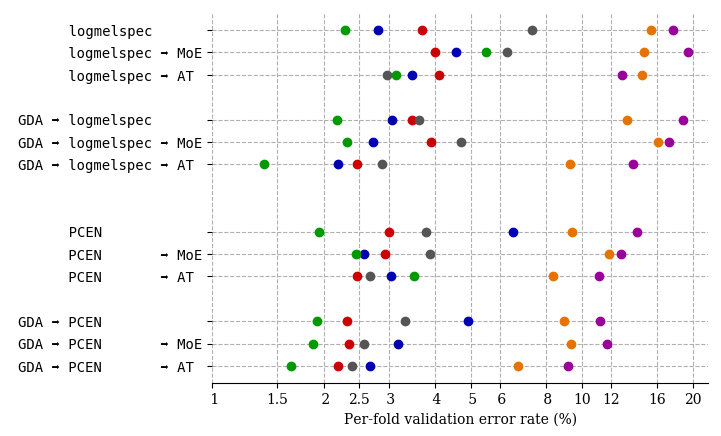

In [50]:
model_names = [
#    "icassp-convnet", "icassp-convnet_aug-all-but-noise",
#    "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise",
#    "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise",
#    "pcen-convnet", "pcen-convnet_aug-all-but-noise",
#    "pcen-ntt-convnet", "pcen-ntt-convnet_aug-all-but-noise",
#    "pcen-add-convnet", "pcen-add-convnet_aug-all-but-noise",
]

model_names = [
    "icassp-convnet", "icassp-ntt-convnet", "icassp-add-convnet",
    "icassp-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all-but-noise",
    "pcen-convnet", "pcen-ntt-convnet", "pcen-add-convnet",
    "pcen-convnet_aug-all-but-noise", "pcen-ntt-convnet_aug-all-but-noise", "pcen-add-convnet_aug-all-but-noise"
]

plt.gca().invert_yaxis()

colors = [
    "#CB0003", # RED
    "#E67300", # ORANGE
    "#990099", # PURPLE
    "#0000B2", # BLUE
    "#009900", # GREEN
#    '#008888', # TURQUOISE
#    '#888800', # KAKI
    '#555555', # GREY
]

xticks = np.array([1.0, 1.5, 2, 2.5, 3, 4, 5, 6, 8, 10, 12, 16, 20])
#xticks = np.array(range(1, 20))
plt.xticks(np.log2(xticks))

xtick_strs = []
for xtick in xticks:
    if np.abs(xtick - int(xtick)) == 0:
        xtick_strs.append("{:2d}".format(int(xtick)))
    else:
        xtick_strs.append("{:1.1f}".format(xtick))

print(xtick_strs)
plt.gca().set_xticklabels(xtick_strs, family="serif")
plt.xlim([np.log2(xticks[0]), np.log2(22.0)])

errs = np.zeros((len(model_names), 6))

for fold_id in range(6):
    errs[:, fold_id] =\
        np.log2(100 - np.array([np.median(fold_accs[fold_id][name]) for name in model_names]))
    #ys = [1, 2, 4, 5, 7, 8, 11, 12, 14, 15, 17, 18]
    ys = [1, 2, 3, 5, 6, 7, 10, 11, 12, 14, 15, 16]
    for i in range(len(model_names)):
        plt.plot(errs[i, fold_id], ys[i], 'o', color=colors[fold_id]);
    
ytick_dict = {
    "icassp-convnet":                       "       logmelspec      ",
    "icassp-convnet_aug-all-but-noise":     "GDA ➡ logmelspec      ",
    ##
    "icassp-ntt-convnet":                   "      logmelspec ➡ MoE",
    "icassp-ntt-convnet_aug-all-but-noise": "GDA ➡ logmelspec ➡ MoE",
    ##
    "icassp-add-convnet":                   "      logmelspec ➡ AT ",
    "icassp-add-convnet_aug-all-but-noise": "GDA ➡ logmelspec ➡ AT ",
    ###
    ###
    "pcen-convnet":                         "       PCEN            ",
    "pcen-convnet_aug-all-but-noise":       "GDA ➡ PCEN            ",
    ##
    "pcen-ntt-convnet":                     "      PCEN       ➡ MoE",
    "pcen-ntt-convnet_aug-all-but-noise":   "GDA ➡ PCEN       ➡ MoE",
    ##
    "pcen-add-convnet":                     "      PCEN       ➡ AT ",
    "pcen-add-convnet_aug-all-but-noise":   "GDA ➡ PCEN       ➡ AT ",
}

plt.yticks(ys)
plt.gca().set_yticklabels([ytick_dict[m] for m in model_names], family="monospace")

plt.xlabel("Per-fold validation error rate (%)", family="serif")

        
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().grid(linestyle="--")

plt.savefig('fig_per-fold-validation.svg', bbox_inches="tight")

<module 'numpy' from '/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/numpy/__init__.py'>

In [134]:
np.sum(pareto > 0, axis=1)

array([ 1,  4,  0,  1,  1,  7,  4,  7,  5,  7,  9, 11])

In [22]:
n_val_trials = 1

model_names = [
    "icassp-convnet", "icassp-convnet_aug-all-but-noise", "icassp-convnet_aug-all", 
    "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all",
    "pcen-convnet", "pcen-convnet_aug-all-but-noise", "pcen-convnet_aug-all",
    "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all",
    "pcen-add-convnet", "pcen-add-convnet_aug-all-but-noise", "pcen-add-convnet_aug-all",
    "pcen-ntt-convnet_aug-all-but-noise", "pcen-ntt-convnet_aug-all",
    "pcen-addntt-convnet_aug-all-but-noise",
]
n_models = len(model_names)
model_val_accs = {}
model_test_accs = {}
    
# Loop over models.
for model_id, model_name in enumerate(model_names):

    model_dir = os.path.join(models_dir, model_name)
    model_val_accs[model_name] = np.zeros((6,))
    model_test_accs[model_name] = np.zeros((6,))

    for test_unit_id in range(6):
                
        # TRIAL SELECTION
        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)
        val_accs = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_acc = max(history_df["Validation accuracy (%)"])
            except:
                val_acc = 0.0
            val_accs.append(val_acc)

        val_accs = np.array(val_accs)
        trial_id = np.argmax(val_accs)

        
        # VALIDATION SET EVALUATION
        trial_str = "trial-" + str(trial_id)
        trial_dir = os.path.join(test_unit_dir, trial_str)
        
        fns, fps, tns, tps = [], [], [], []
        validation_units = localmodule.fold_units()[test_unit_id][2]
        
        for val_unit_str in validation_units:
            predictions_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + val_unit_str,
                "clip-predictions.csv"
            ])
            prediction_path = os.path.join(
                trial_dir, predictions_name)

            # Load prediction.
            with open(prediction_path, 'r') as f:
                reader = csv.reader(f)
                rows = list(reader)
            rows = [",".join(row) for row in rows]
            rows = rows[1:]
            rows = "\n".join(rows)

            # Parse rows with correct header.
            df = pd.read_csv(StringIO(rows),
                names=[
                    "Dataset",
                    "Test unit",
                    "Prediction unit",
                    "Timestamp",
                    "Center Freq (Hz)",
                    "Augmentation",
                    "Key",
                    "Ground truth",
                    "Predicted probability"])
            y_pred = np.array(df["Predicted probability"])
            y_pred = (y_pred > 0.5).astype('int')

            # Load ground truth.
            y_true = np.array(df["Ground truth"])
            
            # Compute confusion matrix.
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                y_true, y_pred).ravel()
            
            tns.append(tn)
            fps.append(fp)
            fns.append(fn)
            tps.append(tp)


        tn = sum(tns)
        tp = sum(tps)
        fn = sum(fns)
        fp = sum(fps)
        val_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
        model_val_accs[model_name][test_unit_id] = val_acc

        
        # TEST SET EVALUATION
        trial_dir = os.path.join(
            test_unit_dir, trial_str)
        predictions_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "clip-predictions.csv"
        ])
        prediction_path = os.path.join(
            trial_dir, predictions_name)
        
        # Load prediction.
        with open(prediction_path, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        rows = [",".join(row) for row in rows]
        rows = rows[1:]
        rows = "\n".join(rows)

        # Parse rows with correct header.
        df = pd.read_csv(StringIO(rows),
            names=[
                "Dataset",
                "Test unit",
                "Prediction unit",
                "Timestamp",
                "Center Freq (Hz)",
                "Augmentation",
                "Key",
                "Ground truth",
                "Predicted probability"])
        y_pred = np.array(df["Predicted probability"])
        y_pred = (y_pred > 0.5).astype('int')

        # Load ground truth.
        y_true = np.array(df["Ground truth"])

        # Compute confusion matrix.
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
            y_true, y_pred).ravel()

        test_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
        model_test_accs[model_name][test_unit_id] = test_acc

In [23]:
model_names

['icassp-convnet',
 'icassp-convnet_aug-all-but-noise',
 'icassp-convnet_aug-all',
 'icassp-ntt-convnet',
 'icassp-ntt-convnet_aug-all-but-noise',
 'icassp-ntt-convnet_aug-all',
 'pcen-convnet',
 'pcen-convnet_aug-all-but-noise',
 'pcen-convnet_aug-all',
 'icassp-add-convnet',
 'icassp-add-convnet_aug-all-but-noise',
 'icassp-add-convnet_aug-all',
 'pcen-add-convnet',
 'pcen-add-convnet_aug-all-but-noise',
 'pcen-add-convnet_aug-all',
 'pcen-ntt-convnet_aug-all-but-noise',
 'pcen-ntt-convnet_aug-all',
 'pcen-addntt-convnet_aug-all-but-noise']

In [24]:
model_diagrams = {
    "icassp-convnet":                       "                  melspec -> log           ",
    "icassp-convnet_aug-all-but-noise":     "         geom  -> melspec -> log           ",
    "icassp-convnet_aug-all":               "(noise + geom) -> melspec -> log           ",
    "icassp-ntt-convnet":                   "                  melspec -> log  -> NTT   ",
    "icassp-ntt-convnet_aug-all-but-noise": "         geom  -> melspec -> log  -> NTT   ",
    "icassp-ntt-convnet_aug-all":           "(noise + geom) -> melspec -> log  -> NTT   ",
    "pcen-convnet":                         "                  melspec -> PCEN          ",
    "pcen_convnet_aug-all-but-noise":       "         geom  -> melspec -> PCEN          ",
    "pcen-convnet_aug-all":                 "(noise + geom) -> melspec -> PCEN          ",
    "icassp-add-convnet":                   "                  melspec -> log  -> CONCAT",
    "icassp-add-convnet_aug-all-but-noise": "         geom  -> melspec -> log  -> CONCAT",
    "icassp-add-convent_aug-all":           "(noise + geom) -> melspec -> log  -> CONCAT",
    "pcen-add-convnet":                     "                  melspec -> PCEN -> CONCAT",
    "pcen-add-convnet_aug-all-but-noise":   "         geom  -> melspec -> PCEN -> CONCAT",
    "pcen-add-convnet_aug-all":             "(noise + geom) -> melspec -> PCEN -> CONCAT",
    "pcen-ntt-convnet_aug-all-but-noise":   "         geom  -> melspec -> PCEN -> NTT   ",
    "pcen-ntt-convnet_aug-all":             "(noise + geom) -> melspec -> PCEN -> NTT   ",
    "pcen-addntt-convnet_aug-all":          "(noise + geom) -> melspec -> PCEN -> AFFINE"}



<Figure size 648x432 with 0 Axes>

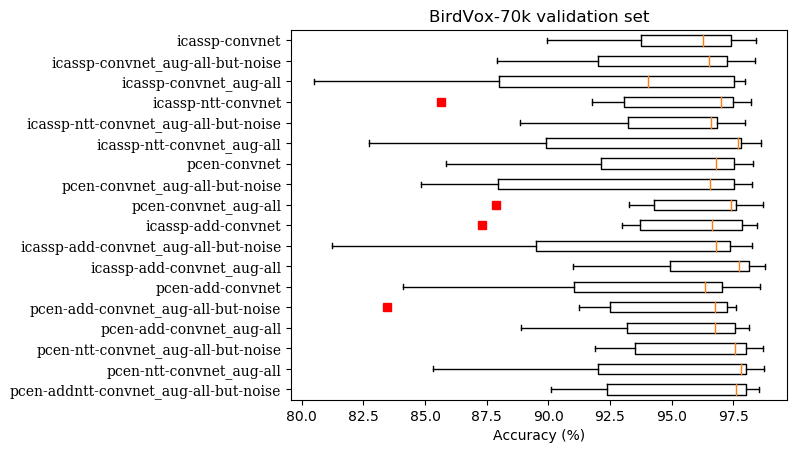

In [25]:
plt.figure(figsize=(9, 6))
plt.rcdefaults()
fig, ax = plt.subplots()
plt.boxplot(np.stack(model_val_accs.values()).T, 0, 'rs', 0)
#plt.ylim((-5.0, 1.0))
plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(model_names)
plt.gca().invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('BirdVox-70k validation set')
plt.show()

<Figure size 900x600 with 0 Axes>

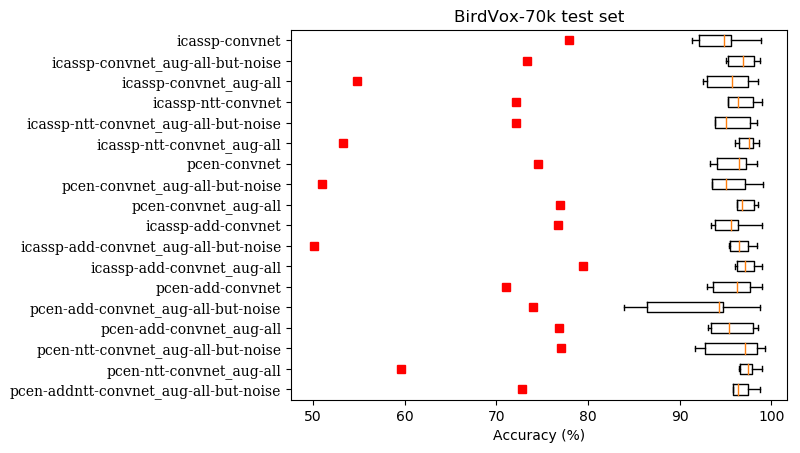

In [26]:
plt.figure(figsize=(9, 6))
plt.rcdefaults()
fig, ax = plt.subplots()
plt.boxplot(np.stack(model_test_accs.values()).T, 0, 'rs', 0)
#plt.ylim((-5.0, 1.0))
plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(model_names)
plt.gca().invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('BirdVox-70k test set')
plt.show()

In [5]:
model_test_accs

{'icassp-add-convnet': array([ 71.01845523,  95.43340381,  98.93558652,  97.03647416,
         93.00918836,  97.9602281 ]),
 'icassp-add-convnet_aug-all': array([ 77.06766917,  96.15221987,  99.26478657,  98.49924012,
         98.05513017,  91.6873812 ]),
 'icassp-add-convnet_aug-all-but-noise': array([ 59.60355434,  97.09302326,  98.9739932 ,  97.74886018,
         96.43950995,  98.00409417]),
 'icassp-convnet': array([ 50.99111415,  93.48837209,  99.10018655,  96.58054711,
         93.49157734,  97.29492616]),
 'icassp-convnet_aug-all': array([ 73.95762133,  94.77801268,  98.76549984,  94.57636778,
         83.8820827 ,  94.04152654]),
 'icassp-convnet_aug-all-but-noise': array([ 50.0683527 ,  97.05073996,  98.46373313,  95.82066869,
         95.42113323,  97.60929961]),
 'icassp-ntt-convnet': array([ 54.81886535,  94.32346723,  98.60089981,  97.53039514,
         92.58805513,  97.19988302]),
 'icassp-ntt-convnet_aug-all': array([ 76.74299385,  96.0359408 ,  99.02885987,  93.43655015

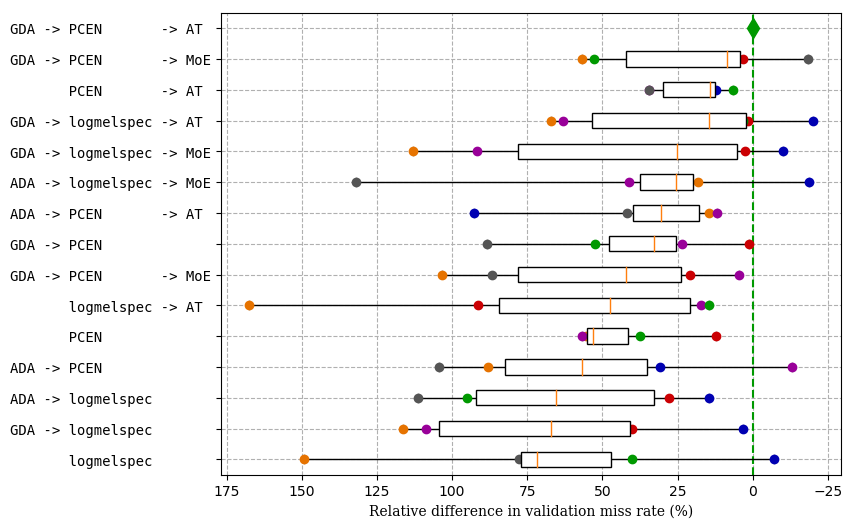

[79.46001367 97.05073996 98.99593987 98.44224924 97.19754977 96.00087732]
[73.95762133 94.77801268 98.76549984 94.57636778 83.8820827  94.04152654]


<Figure size 640x480 with 0 Axes>

In [28]:
ablation_reference_name = "pcen-add-convnet_aug-all-but-noise"
ablation_names = [x for x in list(model_val_accs.keys()) if x not in
    ["icassp-add-convnet_aug-all",
     ablation_reference_name,
     "icassp-ntt-convnet",
     "pcen-addntt-convnet_aug-all-but-noise"]]

ablation_names = list(reversed(ablation_names))
ytick_dict = {
    "icassp-convnet":                       "       logmelspec       ",
    "icassp-convnet_aug-all-but-noise":     "GDA -> logmelspec       ",
    "icassp-convnet_aug-all":               "ADA -> logmelspec       ",
    ##
    "icassp-ntt-convnet":                   "       logmelspec -> MoE",
    "icassp-ntt-convnet_aug-all-but-noise": "GDA -> logmelspec -> MoE",
    "icassp-ntt-convnet_aug-all":           "ADA -> logmelspec -> MoE",
    ##
    "icassp-add-convnet":                   "       logmelspec -> AT ",
    "icassp-add-convnet_aug-all-but-noise": "GDA -> logmelspec -> AT ",
    "icassp-add-convnet_aug-all":           "ADA -> logmelspec -> AT ",
    ###
    ###
    "pcen-convnet":                         "       PCEN             ",
    "pcen-convnet_aug-all-but-noise":       "GDA -> PCEN             ",
    "pcen-convnet_aug-all":                 "ADA -> PCEN             ",
    ##
    "pcen-ntt-convnet":                     "       PCEN       -> MoE",
    "pcen-ntt-convnet_aug-all-but-noise":   "GDA -> PCEN       -> MoE",
    "pcen-ntt-convnet_aug-all":             "GDA -> PCEN       -> MoE",
    ##
    "pcen-add-convnet":                     "       PCEN       -> AT ",
    "pcen-add-convnet_aug-all-but-noise":   "GDA -> PCEN       -> AT ",
    "pcen-add-convnet_aug-all":             "ADA -> PCEN       -> AT ",
    ###
    "pcen-addntt-convnet_aug-all-but-noise":"GDA -> PCEN       -> AT + MoE ",
}
reference_val_accs = model_val_accs[ablation_reference_name]
ablation_val_accs = [
    100 * (reference_val_accs - model_val_accs[name]) / (100 - reference_val_accs)
    for name in ablation_names]


ablation_names = list(reversed([ablation_names[i] for i in np.argsort(np.median(ablation_val_accs,axis=1))]))
ablation_val_accs = list(reversed([ablation_val_accs[i] for i in np.argsort(np.median(ablation_val_accs,axis=1))]))
ablation_val_accs = np.array(ablation_val_accs)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 6))
plt.grid(linestyle="--")
plt.axvline(0.0, linestyle="--", color="#009900")
plt.plot([0.0], [1+len(ablation_val_accs)], 'd',
    color="#009900", markersize=10.0)

colors = [
    "#CB0003", # RED
    "#E67300", # ORANGE
    "#990099", # PURPLE
    "#0000B2", # BLUE
    "#009900", # GREEN
#    '#008888', # TURQUOISE
#    '#888800', # KAKI
    '#555555', # GREY
]


plt.boxplot(ablation_val_accs.T, 0, 'rs', 0,
            whis=100000, patch_artist=True, boxprops={"facecolor": "w"})
for i, color in enumerate(colors):
    plt.plot(np.array(ablation_val_accs[:,i]),
        range(1, 1+len(ablation_val_accs[:,i])), 'o', color=color)
fig.canvas.draw()

plt.setp(ax.get_yticklabels(), family="serif")
#ax.set_yticklabels([
#    "adaptive threshold\nreplaced by\n mixture of experts",
#    "no data augmentation",
#    "addition of noise\nto frontend but not to\nauxiliary features",
#    "no context adaptation",
#    "PCEN\nreplaced by\nlog-mel frontend",
#    "state of the art [X]"])
ax.set_yticks(range(1, 2+len(ablation_val_accs)))
ax.set_yticklabels([ytick_dict[x] for x in
    (ablation_names + [ablation_reference_name])], family="monospace")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_xlabel('Relative difference in validation miss rate (%)', family="serif")
plt.ylim([0.5, 1.5+len(ablation_names)])
plt.show()


reference_test_accs = model_test_accs[ablation_reference_name]
print(reference_test_accs)
baseline_test_accs = model_test_accs["icassp-convnet_aug-all"]
print(baseline_test_accs)

plt.savefig('fig_exhaustive-per-fold-validation.eps', bbox_inches="tight")
plt.savefig('fig_exhaustive-per-fold-validation.png', bbox_inches="tight", dpi=1000)

[79.46001367 97.05073996 98.99593987 98.44224924 97.19754977 96.00087732]
[73.95762133 94.77801268 98.76549984 94.57636778 83.8820827  94.04152654]


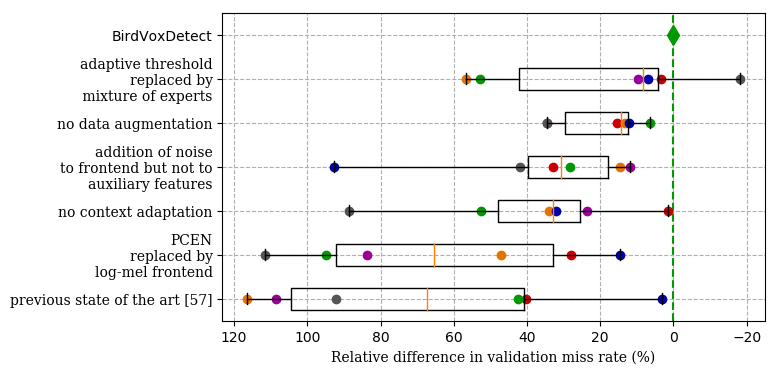

In [51]:
%matplotlib inline
ablation_reference_name = "pcen-add-convnet_aug-all-but-noise"
#ablation_names = [x for x in list(model_val_accs.keys()) if x not in
#    ["icassp-add-convnet_aug-all",
#     ablation_reference_name,
#     "icassp-ntt-convnet",
#     "pcen-addntt-convnet_aug-all-but-noise"]]
ablation_names = [
    "pcen-ntt-convnet_aug-all-but-noise",
    "pcen-add-convnet",
    "pcen-add-convnet_aug-all",
    "pcen-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all"
]

ablation_names = list(reversed(ablation_names))
ytick_dict = {
    "icassp-convnet":                       "       logmelspec       ",
    "icassp-convnet_aug-all-but-noise":     "GDA -> logmelspec       ",
    "icassp-convnet_aug-all":               "ADA -> logmelspec       ",
    ##
    "icassp-ntt-convnet":                   "       logmelspec -> MoE",
    "icassp-ntt-convnet_aug-all-but-noise": "GDA -> logmelspec -> MoE",
    "icassp-ntt-convnet_aug-all":           "ADA -> logmelspec -> MoE",
    ##
    "icassp-add-convnet":                   "       logmelspec -> AT ",
    "icassp-add-convnet_aug-all-but-noise": "GDA -> logmelspec -> AT ",
    "icassp-add-convnet_aug-all":           "ADA -> logmelspec -> AT ",
    ###
    ###
    "pcen-convnet":                         "       PCEN             ",
    "pcen-convnet_aug-all-but-noise":       "GDA -> PCEN             ",
    "pcen-convnet_aug-all":                 "ADA -> PCEN             ",
    ##
    "pcen-ntt-convnet":                     "       PCEN       -> MoE",
    "pcen-ntt-convnet_aug-all-but-noise":   "GDA -> PCEN       -> MoE",
    "pcen-ntt-convnet_aug-all":             "GDA -> PCEN       -> MoE",
    ##
    "pcen-add-convnet":                     "       PCEN       -> AT ",
    "pcen-add-convnet_aug-all-but-noise":   "GDA -> PCEN       -> AT ",
    "pcen-add-convnet_aug-all":             "ADA -> PCEN       -> AT ",
    ###
    "pcen-addntt-convnet_aug-all-but-noise":"GDA -> PCEN       -> AT + MoE ",
}
reference_val_accs = model_val_accs[ablation_reference_name]
ablation_val_accs = [
    100 * (reference_val_accs - model_val_accs[name]) / (100 - reference_val_accs)
    for name in ablation_names]


ablation_names = list(reversed([ablation_names[i] for i in np.argsort(np.median(ablation_val_accs,axis=1))]))
ablation_val_accs = list(reversed([ablation_val_accs[i] for i in np.argsort(np.median(ablation_val_accs,axis=1))]))
ablation_val_accs = np.array(ablation_val_accs)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(7, 4))
plt.grid(linestyle="--")
plt.axvline(0.0, linestyle="--", color="#009900")
plt.plot([0.0], [1+len(ablation_val_accs)], 'd',
    color="#009900", markersize=10.0)

colors = [
    "#CB0003", # RED
    "#E67300", # ORANGE
    "#990099", # PURPLE
    "#0000B2", # BLUE
    "#009900", # GREEN
#    '#008888', # TURQUOISE
#    '#888800', # KAKI
    '#555555', # GREY
]


for i, color in enumerate(colors):
    plt.plot(np.array(ablation_val_accs[:,i]),
        range(1, 1+len(ablation_val_accs[:,i])), 'o', color=color)
fig.canvas.draw()
plt.boxplot(ablation_val_accs.T, 0, 'rs', 0,
            whis=100000)


plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(reversed([
    "BirdVoxDetect",
    "adaptive threshold\nreplaced by\n mixture of experts",
    "no data augmentation",
    "addition of noise\nto frontend but not to\nauxiliary features",
    "no context adaptation",
    "PCEN\nreplaced by\nlog-mel frontend",
    "previous state of the art [57]"]))
ax.set_yticks(range(1, 2+len(ablation_val_accs)))
#ax.set_yticklabels([ytick_dict[x] for x in
#    (ablation_names + [ablation_reference_name])], family="monospace")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_xlabel('Relative difference in validation miss rate (%)', family="serif")
plt.ylim([0.5, 1.5+len(ablation_names)])
#plt.show()


reference_test_accs = model_test_accs[ablation_reference_name]
print(reference_test_accs)
baseline_test_accs = model_test_accs["icassp-convnet_aug-all"]
print(baseline_test_accs)

plt.savefig('fig_ablation-study.eps', bbox_inches="tight")
plt.savefig('fig_ablation-study.svg', bbox_inches="tight")
plt.savefig('fig_ablation-study.png', bbox_inches="tight", dpi=1000)

In [45]:
2

2

In [51]:
n_trials = 10
report = {}

for model_name in model_names:

    model_dir = os.path.join(models_dir, model_name)


    # Initialize dictionaries
    model_report = {
        "validation": {},
        "test_cv-acc_th=0.5": {}
    }

    # Initialize matrix of validation accuracies.
    val_accs = np.zeros((n_units, n_trials))
    val_tps = np.zeros((n_units, n_trials))
    val_tns = np.zeros((n_units, n_trials))
    val_fps = np.zeros((n_units, n_trials))
    val_fns = np.zeros((n_units, n_trials))
    
    test_accs = np.zeros((n_units, n_trials))
    test_tps = np.zeros((n_units, n_trials))
    test_tns = np.zeros((n_units, n_trials))
    test_fps = np.zeros((n_units, n_trials))
    test_fns = np.zeros((n_units, n_trials))


    # Loop over test units.
    for test_unit_id, test_unit_str in enumerate(units):


        # Define directory for test unit.
        test_unit_dir = os.path.join(model_dir, test_unit_str)


        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]


        # Loop over trials.
        for trial_id in range(n_trials):


            # Define directory for trial.
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)


            # Initialize.
            break_switch = False
            val_fn = 0
            val_fp = 0
            val_tn = 0
            val_tp = 0


            # Loop over validation units.
            for val_unit_str in validation_units:

                predictions_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    "trial-" + str(trial_id),
                    "predict-" + val_unit_str,
                    "clip-predictions.csv"
                ])
                prediction_path = os.path.join(
                    trial_dir, predictions_name)

                # Load prediction.
                csv_file = pd.read_csv(prediction_path)
                
                # Parse prediction.
                if model_name == "icassp-convnet_aug-all":
                    y_pred = np.array(csv_file["Predicted probability"])
                    y_true = np.array(csv_file["Ground truth"])
                elif model_name == "pcen-add-convnet_aug-all-but-noise":
                    with open(prediction_path, 'r') as f:
                        reader = csv.reader(f)
                        rows = list(reader)
                    rows = [",".join(row) for row in rows]
                    rows = rows[1:]
                    rows = "\n".join(rows)

                    # Parse rows with correct header.
                    df = pd.read_csv(StringIO(rows),
                        names=[
                            "Dataset",
                            "Test unit",
                            "Prediction unit",
                            "Timestamp",
                            "Center Freq (Hz)",
                            "Augmentation",
                            "Key",
                            "Ground truth",
                            "Predicted probability"])
                    y_pred = np.array(df["Predicted probability"])
                    y_true = np.array(df["Ground truth"])
                    
                # Threshold.
                y_pred = (y_pred > 0.5).astype('int')

                # Check that CSV file is not corrupted.
                if len(y_pred) == 0:
                    break_switch = True
                    break

                # Compute confusion matrix.
                tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                    y_true, y_pred).ravel()

                val_fn = val_fn + fn
                val_fp = val_fp + fp
                val_tn = val_tn + tn
                val_tp = val_tp + tp


            if not break_switch:
                val_acc = (val_tn+val_tp) / (val_fn+val_fp+val_tn+val_tp)
            else:
                val_fn = 0
                val_fp = 0
                val_tn = 0
                val_tp = 0
                val_acc = 0.0
            
            val_fns[test_unit_id, trial_id] = val_fn
            val_fps[test_unit_id, trial_id] = val_fp
            val_tns[test_unit_id, trial_id] = val_tn
            val_tps[test_unit_id, trial_id] = val_tp
            val_accs[test_unit_id, trial_id] = val_acc


            # Initialize.
            predictions_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                "trial-" + str(trial_id),
                "predict-" + test_unit_str,
                "clip-predictions.csv"
            ])
            prediction_path = os.path.join(
                trial_dir, predictions_name)


            with open(prediction_path, 'r') as f:
                reader = csv.reader(f)
                rows = list(reader)
            rows = [",".join(row) for row in rows]
            rows = rows[1:]
            rows = "\n".join(rows)

            # Parse rows with correct header.
            df = pd.read_csv(StringIO(rows),
                names=[
                    "Dataset",
                    "Test unit",
                    "Prediction unit",
                    "Timestamp",
                    "Center Freq (Hz)",
                    "Augmentation",
                    "Key",
                    "Ground truth",
                    "Predicted probability"])
            y_pred = np.array(df["Predicted probability"])
            y_pred = (y_pred > 0.5).astype('int')
            y_true = np.array(df["Ground truth"])

            # Check that CSV file is not corrupted.
            if len(y_pred) == 0:
                test_tn, test_fp, test_fn, test_tp = 0, 0, 0, 0
                test_acc = 0.0
            else:
                # Load ground truth.
                y_true = np.array(df["Ground truth"])
                # Compute confusion matrix.
                test_tn, test_fp, test_fn, test_tp =\
                    sklearn.metrics.confusion_matrix(
                        y_true, y_pred).ravel()
                test_acc = (test_tn+test_tp) / (test_fn+test_fp+test_tn+test_tp)


            test_fns[test_unit_id, trial_id] = test_fn
            test_fps[test_unit_id, trial_id] = test_fp
            test_tns[test_unit_id, trial_id] = test_tn
            test_tps[test_unit_id, trial_id] = test_tp
            test_accs[test_unit_id, trial_id] = test_acc 
            
    model_report["validation"]["FN"] = test_fn
    model_report["validation"]["FP"] = test_fp
    model_report["validation"]["TN"] = test_tn
    model_report["validation"]["TP"] = test_tp
    model_report["validation"]["accuracy"] = val_accs
    
    best_trials = np.argsort(model_report["validation"]["accuracy"], axis=1)
    model_report["validation"]["best_trials"] = best_trials
    
    model_report["test_cv-acc_th=0.5"]["FN"] = test_fns
    model_report["test_cv-acc_th=0.5"]["FP"] = test_fps
    model_report["test_cv-acc_th=0.5"]["TN"] = test_tns
    model_report["test_cv-acc_th=0.5"]["TP"] = test_tps
    model_report["test_cv-acc_th=0.5"]["accuracy"] = test_accs

    
    cv_accs = []
    for eval_trial_id in range(5):
        cv_fn = 0
        cv_fp = 0
        cv_tn = 0
        cv_tp = 0

        for test_unit_id, test_unit_str in enumerate(units):

            best_trials = model_report["validation"]["best_trials"]
            unit_best_trials = best_trials[test_unit_id, -5:]
            unit_best_trials = sorted(unit_best_trials)
            trial_id = unit_best_trials[eval_trial_id]

            cv_fn = cv_fn + model_report["test_cv-acc_th=0.5"]["FN"][test_unit_id, trial_id]
            cv_fp = cv_fp + model_report["test_cv-acc_th=0.5"]["FP"][test_unit_id, trial_id]
            cv_tn = cv_tn + model_report["test_cv-acc_th=0.5"]["TN"][test_unit_id, trial_id]
            cv_tp = cv_tp + model_report["test_cv-acc_th=0.5"]["TP"][test_unit_id, trial_id]

        cv_acc = (cv_tn+cv_tp) / (cv_tn+cv_tp+cv_fn+cv_fp)
        cv_accs.append(cv_acc)

        
    model_report["test_cv-acc_th=0.5"]["global_acc"] = np.array(cv_accs)
    report[model_name] = model_report
    
    print(model_name, ": acc = {:5.2f}% ± {:3.1f}".format(
        100*np.mean(report[model_name]['test_cv-acc_th=0.5']['global_acc']),
        100*np.std(report[model_name]['test_cv-acc_th=0.5']['global_acc'])))
    
    
#print(report['icassp-convnet_aug-all']['test_cv-acc_th=0.5']['global_acc'])
#print(report['pcen-add-convnet_aug-all-but-noise']['test_cv-acc_th=0.5']['global_acc'])

icassp-convnet : acc = 85.25% ± 5.8
icassp-convnet_aug-all-but-noise : acc = 84.71% ± 7.5
icassp-convnet_aug-all : acc = 94.85% ± 0.8
icassp-ntt-convnet : acc = 83.77% ± 7.8
icassp-ntt-convnet_aug-all-but-noise : acc = 80.94% ± 7.3
icassp-ntt-convnet_aug-all : acc = 89.68% ± 5.8
pcen-convnet : acc = 73.29% ± 4.5
pcen-convnet_aug-all-but-noise : acc = 62.21% ± 3.9
pcen-convnet_aug-all : acc = 82.46% ± 11.0
icassp-add-convnet : acc = 71.36% ± 11.5
icassp-add-convnet_aug-all-but-noise : acc = 78.84% ± 10.5
icassp-add-convnet_aug-all : acc = 75.24% ± 6.5
pcen-add-convnet : acc = 93.15% ± 2.7
pcen-add-convnet_aug-all-but-noise : acc = 95.82% ± 0.5
pcen-add-convnet_aug-all : acc = 74.17% ± 4.9
pcen-ntt-convnet_aug-all-but-noise : acc = 91.82% ± 4.5
pcen-ntt-convnet_aug-all : acc = 69.24% ± 7.2
pcen-addntt-convnet_aug-all-but-noise : acc = 74.82% ± 13.4


In [50]:
list(report.keys())

['icassp-convnet', 'icassp-convnet_aug-all-but-noise']

In [52]:
icassp_accs = report['icassp-convnet_aug-all']['test_cv-acc_th=0.5']['global_acc']
print("ICASSP 2018: acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(icassp_accs), 100*np.std(icassp_accs)))

spl_accs = report['pcen-add-convnet_aug-all-but-noise']['test_cv-acc_th=0.5']['global_acc']
print("SPL 2018:    acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(spl_accs), 100*np.std(spl_accs)))

ICASSP 2018: acc = 94.85% ± 0.8
SPL 2018:    acc = 95.82% ± 0.5


In [115]:
n_trials = 5
model_name = "skm-cv"
model_dir = os.path.join(models_dir, model_name)


skm_fns = np.zeros((n_trials, n_units))
skm_fps = np.zeros((n_trials, n_units))
skm_tns = np.zeros((n_trials, n_units))
skm_tps = np.zeros((n_trials, n_units))


# Loop over trials.
for trial_id in range(n_trials):

    
    # Loop over units.
    for test_unit_id, test_unit_str in enumerate(units):

        # Define path to predictions.
        unit_dir = os.path.join(model_dir, test_unit_str)
        trial_str = "trial-" + str(5 + trial_id)
        trial_dir = os.path.join(unit_dir, trial_str)
        predictions_name = "_".join([
            dataset_name,
            "skm-proba",
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "clip-predictions.csv"
        ])
        predictions_path = os.path.join(trial_dir, predictions_name)

        # Remove header, which has too few columns (hack).
        with open(predictions_path, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        rows = [",".join(row) for row in rows]
        rows = rows[1:]
        rows = "\n".join(rows)

        # Parse rows with correct header.
        df = pd.read_csv(StringIO(rows),
            names=[
                "Dataset",
                "Test unit",
                "Prediction unit",
                "Timestamp",
                "Center Freq (Hz)",
                "Augmentation",
                "Key",
                "Ground truth",
                "Predicted probability"])
        
        # Extract y_pred and y_true.
        y_pred = np.array((df["Predicted probability"] > 0.5)).astype("int")
        y_true = np.array(df["Ground truth"])

        # Compute confusion matrix.
        test_tn, test_fp, test_fn, test_tp =\
            sklearn.metrics.confusion_matrix(
                y_true, y_pred).ravel()
            
        skm_fns[trial_id, test_unit_id] = test_fn
        skm_fps[trial_id, test_unit_id] = test_fp
        skm_tns[trial_id, test_unit_id] = test_tn
        skm_tps[trial_id, test_unit_id] = test_tp
        
        
total_skm_fns = np.sum(skm_fns[:, 1:], axis=1)
total_skm_fps = np.sum(skm_fps[:, 1:], axis=1)
total_skm_tns = np.sum(skm_tns[:, 1:], axis=1)
total_skm_tps = np.sum(skm_tps[:, 1:], axis=1)

total_skm_accs = (total_skm_tns+total_skm_tps) / (total_skm_fns+total_skm_fps+total_skm_tns+total_skm_tps)
print("SKM: acc = {:5.2f}% ± {:3.1f}".format(100*np.mean(total_skm_accs), 100*np.std(total_skm_accs)))

SKM: acc = 87.77% ± 0.4


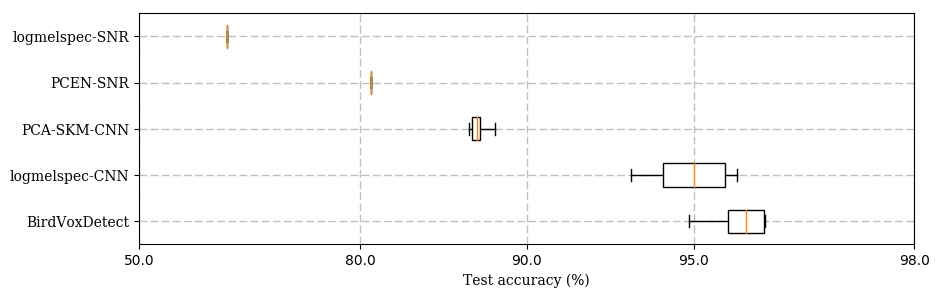

In [120]:
xticks = np.array([2.0, 5.0, 10.0, 20.0, 50.0])
lms_snr_accs = np.repeat([0.652], 5)
pcen_snr_accs = np.repeat([0.809], 5)
skm_accs = total_skm_accs

fig, ax = plt.subplots(figsize=(10, 3))
plt.rcdefaults()
plt.boxplot(np.log2(np.array([
    100*(1-lms_snr_accs),
    100*(1-pcen_snr_accs),
    100*(1-skm_accs),
    100*(1-icassp_accs),
    100*(1-spl_accs)]).T), 0, 'rs', 0,
    whis=100000, patch_artist=True, boxprops={"facecolor": "w"});
plt.xlim(np.log2(np.array([2.0, 50.0])))
plt.xticks(np.log2(xticks))
plt.gca().set_xticklabels([100 - x for x in xticks])

plt.setp(ax.get_yticklabels(), family="serif")
ax.set_yticklabels(["logmelspec-SNR", "PCEN-SNR", "PCA-SKM-CNN", "logmelspec-CNN", "BirdVoxDetect"],
    family="serif")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Test accuracy (%)", family="serif")
plt.gca().yaxis.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
plt.gca().xaxis.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")

plt.savefig('fig_per-fold-test.eps', bbox_inches="tight")

array([[ 34.8       ,  34.8       ,  34.8       ,  34.8       ,  34.8       ],
       [ 19.1       ,  19.1       ,  19.1       ,  19.1       ,  19.1       ],
       [  6.48550929,   5.00254223,   4.18479182,   4.38675781,
          5.68047003],
       [  4.02802102,   3.71165471,   4.34015027,   3.73566465,   5.098582  ]])

In [178]:
np.min(icassp_accs), np.max(icassp_accs)

(0.93514490706739728, 0.95815208180328792)

In [180]:
np.min(spl_accs), np.max(spl_accs)

(0.94901417998983106, 0.96288345291226485)

In [239]:

icassp_fold_accs = report['icassp-convnet_aug-all']['validation']["accuracy"]
spl_fold_accs = report['pcen-add-convnet_aug-all-but-noise']['validation']["accuracy"]
print(np.mean(np.max(icassp_fold_accs, axis=1)), np.mean(np.max(spl_fold_accs, axis=1)))

0.954919296987 0.964616622329
